In [1]:
from google.colab import drive
drive.mount('/content/drive')
#google drive dosyalarimiza erisebilmek icin drive'imizi calisma ortamimiza dahil ediyoruz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
%matplotlib inline

In [3]:
ls -al /content/drive/MyDrive/dataset

total 8
drwx------ 4 root root 4096 Mar 16 09:11 test/
drwx------ 4 root root 4096 Mar 16 09:11 train/


In [4]:
imagePaths = "/content/drive/MyDrive/dataset/train"

In [5]:
batch_size=32
img_height = 255
img_width = 255

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1971 files belonging to 2 classes.
Using 1577 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1971 files belonging to 2 classes.
Using 394 files for validation.


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 255, 255, 3)
(32,)


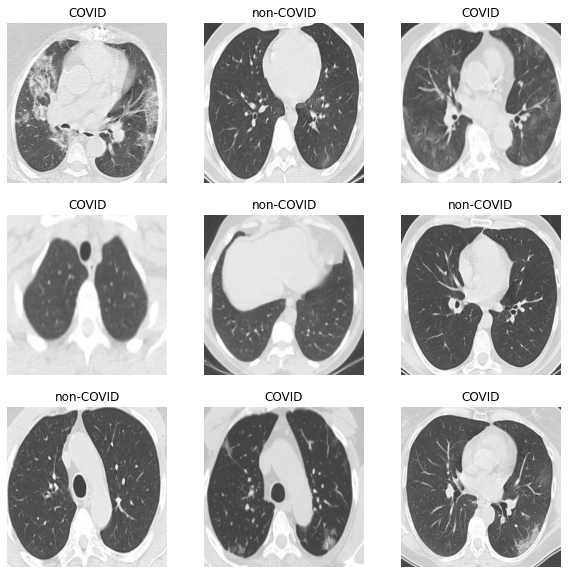

In [8]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.19067532 1.0


In [10]:
model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255),
        Conv2D(32, 3, activation='relu', name='conv_1', padding='SAME'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu',padding='SAME', name='conv_2'),
        MaxPooling2D(pool_size=(8, 8), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=16, activation='relu', name='dense_1'),
        Dense(units=2, activation='softmax', name='dense_2')
    ])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [13]:
def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [14]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [15]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)

Epoch 1/5
50/50 [==============================] - 184s 4s/step - loss: 0.6707 - accuracy: 0.5938 - val_loss: 0.5892 - val_accuracy: 0.6827

Epoch 00001: val_accuracy improved from -inf to 0.68274, saving model to checkpoints_best_only
INFO:tensorflow:Assets written to: checkpoints_best_only/assets
Epoch 2/5
50/50 [==============================] - 184s 4s/step - loss: 0.5058 - accuracy: 0.7413 - val_loss: 0.4826 - val_accuracy: 0.7970

Epoch 00002: val_accuracy improved from 0.68274 to 0.79695, saving model to checkpoints_best_only
INFO:tensorflow:Assets written to: checkpoints_best_only/assets
Epoch 3/5
50/50 [==============================] - 184s 4s/step - loss: 0.3817 - accuracy: 0.8251 - val_loss: 0.5047 - val_accuracy: 0.7792

Epoch 00003: val_accuracy did not improve from 0.79695
Epoch 4/5
50/50 [==============================] - 184s 4s/step - loss: 0.3792 - accuracy: 0.8260 - val_loss: 0.4282 - val_accuracy: 0.8274

Epoch 00004: val_accuracy improved from 0.79695 to 0.82741, 

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 255, 255, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 255, 255, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 255, 255, 8)       2312      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 31, 31, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 7688)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                123024    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3

In [17]:
model.save('model.h5')
#model = load_model('path/to/location')

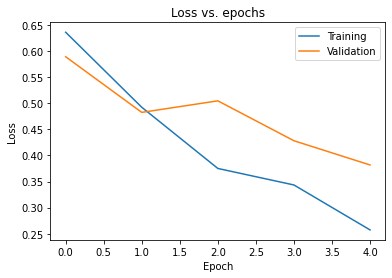

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

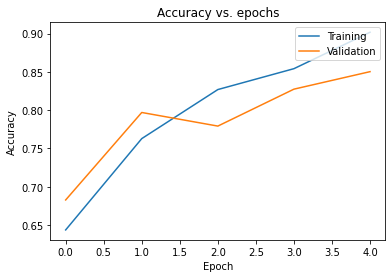

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [26]:
test_image = image.load_img('/content/drive/MyDrive/dataset/test/COVID/Covid (359).png', target_size = (255, 255))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

In [35]:
result = model.predict(test_image)
if result[0][0] < 0.5 and result[0][1] >= 0.5:
  print("non-covid")

else:
  print("covid")

covid


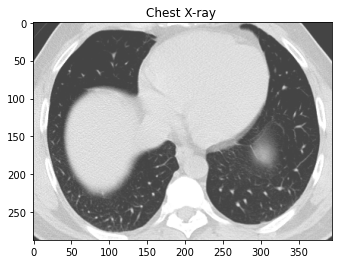

In [38]:
img=mpimg.imread('/content/drive/MyDrive/dataset/test/COVID/Covid (359).png')
imgplot = plt.imshow(img)
plt=plt.title('Chest X-ray ')

In [26]:
#model.evaluate(val_ds, verbose=2)

16/16 - 14s - loss: 1.0088 - accuracy: 0.5806


[1.008750557899475, 0.5806451439857483]